# AVIRIS-NG Methane Mapping

ESE 156 -- Christian Frankenberg
---
Task: -- Find the methane plume!

In [53]:
## Make sure plots are create inline
%matplotlib inline
## The usual packages (numpy, matplotlib, etc)
from RSE_style import *

import os
import spectral.io.envi as envi

figsize(10,8)

In [54]:
from spectral import *

In [55]:
# Return the header associated with an image file (HDR datasets, all AVIRIS-like)
def find_header(imgfile):
  if os.path.exists(imgfile+'.hdr'):
    return imgfile+'.hdr'
  ind = imgfile.rfind('.raw')
  if ind >= 0:
    return imgfile[0:ind]+'.hdr'
  ind = imgfile.rfind('.img')
  if ind >= 0:
    return imgfile[0:ind]+'.hdr'
  raise IOError('No header found for file {0}'.format(imgfile));

In [56]:
# You can download all files from ftp://fluo.gps.caltech.edu/XYZT_ESE156/Data/AVng/
in_file = 'files/ang20150422t162859_rdn_v1f_clip'
in_hdr = find_header(in_file)
img = envi.open(in_hdr, in_file)
wl = np.loadtxt('files/ANGv3_spc_rev_300nm_truncated.wav')
# Color indices for R,G and B
index_r = np.argmin(np.abs(wl[:,1]-0.65))
index_g = np.argmin(np.abs(wl[:,1]-0.473))
index_b = np.argmin(np.abs(wl[:,1]-0.532))
#print index_r,index_g,index_b

In [57]:
print(img.shape)
rgb = img[:,:,[index_r,index_g,index_b]]
print(rgb.shape)

(3569, 598, 432)
(3569, 598, 3)


ImageView object:
  Display bands       :  [0, 1, 2]
  Interpolation       :  <default>
  RGB data limits     :
    R: [-0.06293503195047379, 24.7602481842041]
    G: [-0.041154779493808746, 19.09193992614746]
    B: [-0.061110518872737885, 23.524436950683594]

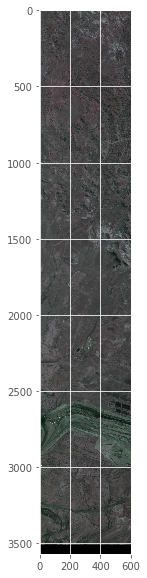

In [58]:
figsize(12,10)
imshow(rgb[:,:,:])

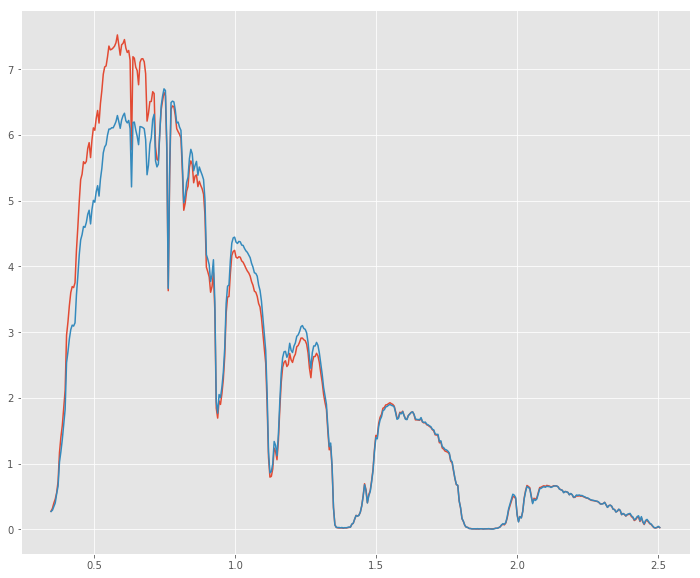

In [59]:
ch4_rad=img[1000,500,:].flatten()
ch4_rad2=img[1500,300,:].flatten()
plt.plot(wl[:,1], ch4_rad)
plt.plot(wl[:,1], ch4_rad2)

In [60]:
from hapi import *

In [62]:
xmin = 1e7/2500
xmax = 1e7/400
storage2cache('CO2_av')
storage2cache('CH4_av')
storage2cache('H2O_av')
#fetch('CO2_av',2,1,xmin,xmax);
#fetch('CH4_av',6,1,xmin,xmax);
#fetch('H2O_av',1,1,xmin,xmax);

                     Lines parsed: 68605
                     Lines parsed: 174475
                     Lines parsed: 111528


In [63]:
p = 850.0
T = 290.0

nu_, cs_co2 = absorptionCoefficient_Voigt(SourceTables='CO2_av',WavenumberStep=0.01, WavenumberRange=[xmin,1e7/350],Environment={'p':p/1013,'T':T})
nu_, cs_ch4 = absorptionCoefficient_Voigt(SourceTables='CH4_av',WavenumberStep=0.01, WavenumberRange=[xmin,1e7/350],Environment={'p':p/1013,'T':T})
nu_, cs_h2o = absorptionCoefficient_Voigt(SourceTables='H2O_av',WavenumberStep=0.01, WavenumberRange=[xmin,1e7/350],Environment={'p':p/1013,'T':T})

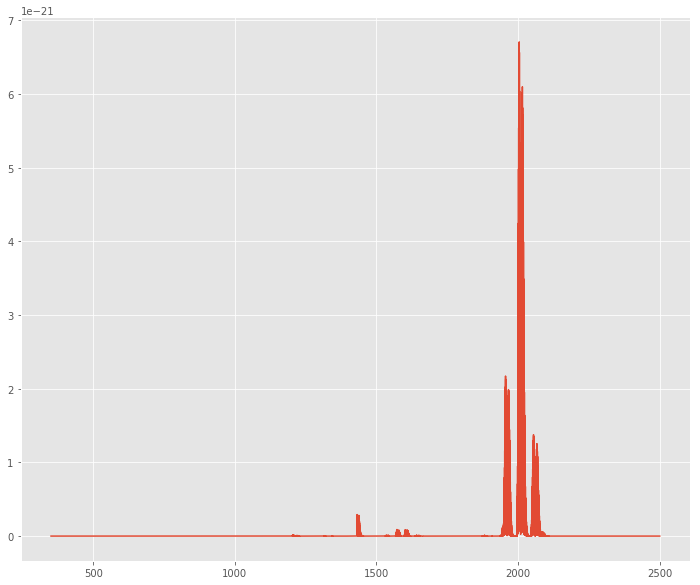

In [72]:
vcd_co2 = 8e21;
vcd_ch4 = 4e19;
vcd_h2o = 5e22;

wl_hr = np.arange(351,2500,0.01)
wl_lr = wl[5:-2,1]*1e3

fco2 = interp1d(1e7/nu_, cs_co2,kind='linear')
cs_co2_wl = fco2(wl_hr);
fch4 = interp1d(1e7/nu_, cs_ch4,kind='linear')
cs_ch4_wl = fch4(wl_hr);
fh2o = interp1d(1e7/nu_, cs_h2o,kind='linear')
cs_h2o_wl = fh2o(wl_hr);
plt.plot(wl_hr, fco2(wl_hr))

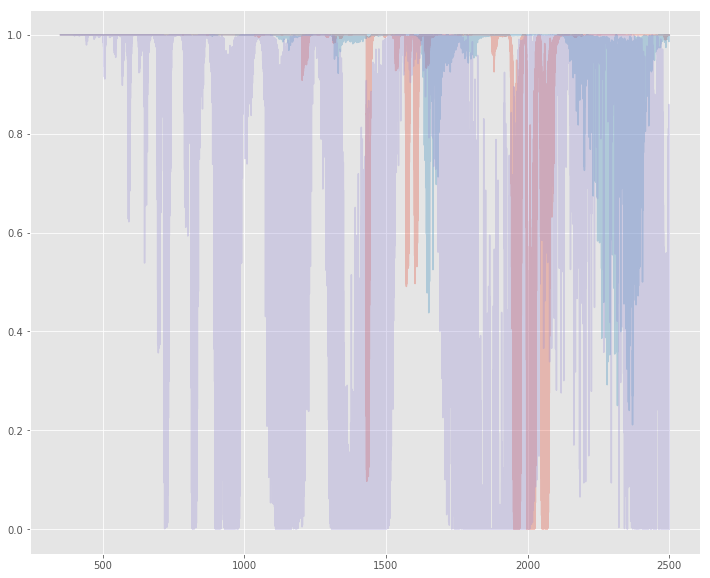

In [73]:

plt.plot(wl_hr, np.exp(-vcd_co2*cs_co2_wl) , alpha=0.3 )
plt.plot(wl_hr, np.exp(-vcd_ch4*cs_ch4_wl) , alpha=0.3 )
plt.plot(wl_hr, np.exp(-vcd_h2o*cs_h2o_wl), alpha=0.3 )

In [74]:

# Import a Gaussian convolution
from scipy.ndimage.filters import gaussian_filter1d
# Import a 1D interpolation routine
from scipy.interpolate import interp1d

# write a separate function to just apply the instrument function (as we do this often:) 
# This could be more sophisticated than a Gaussian line-shape. 
# If we have it in a separate function, things can be easily replaced.
def applyAVng(F):
    co = 2.355
    res = 0.01
    FWHM = 5
    F2 = gaussian_filter1d(F, FWHM/res/co)
    finter = interp1d(wl_hr, F2,kind='linear')
    return finter(wl_lr)
    

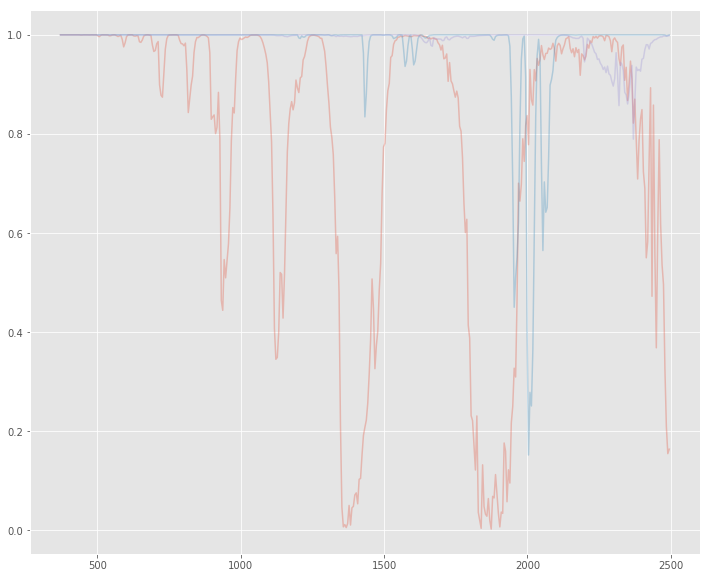

In [75]:
plt.plot(wl_lr, applyAVng(np.exp(-vcd_h2o*cs_h2o_wl)), alpha=0.3 )
plt.plot(wl_lr, applyAVng(np.exp(-vcd_co2*cs_co2_wl)), alpha=0.3 )
plt.plot(wl_lr, applyAVng(np.exp(-vcd_ch4*cs_ch4_wl)), alpha=0.3 )

(2000, 2500)

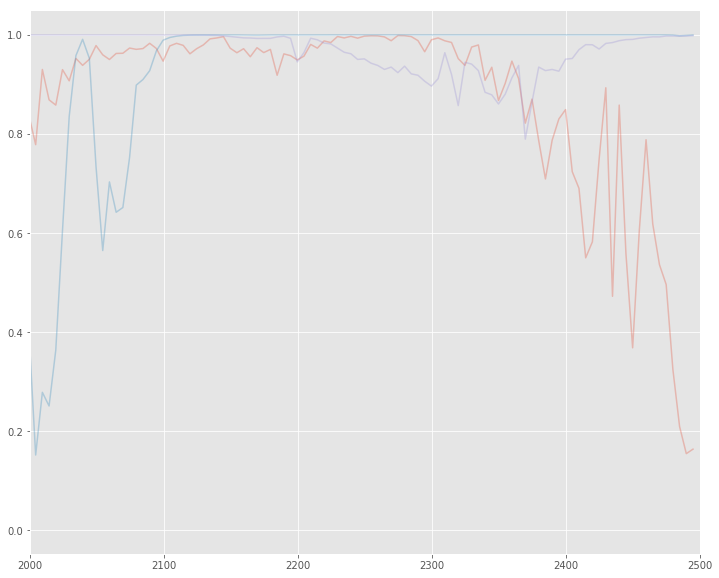

In [76]:
plt.plot(wl_lr, applyAVng(np.exp(-vcd_h2o*cs_h2o_wl)), alpha=0.3 )
plt.plot(wl_lr, applyAVng(np.exp(-vcd_co2*cs_co2_wl)), alpha=0.3 )
plt.plot(wl_lr, applyAVng(np.exp(-vcd_ch4*cs_ch4_wl)), alpha=0.3 )
plt.xlim((2000,2500))